Copyright (c) 2019 Computational-Medicine

# Kiwi seed segmentation from MRI  (work in progress ...)

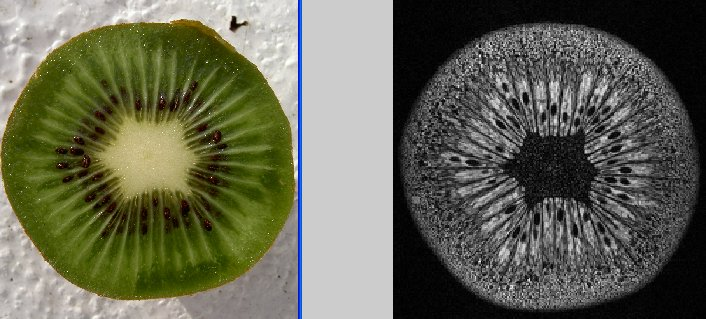

In [1]:
from IPython.display import Image
Image(filename='./assets/kiwi_photo_mri_20050219.jpg', width=600)

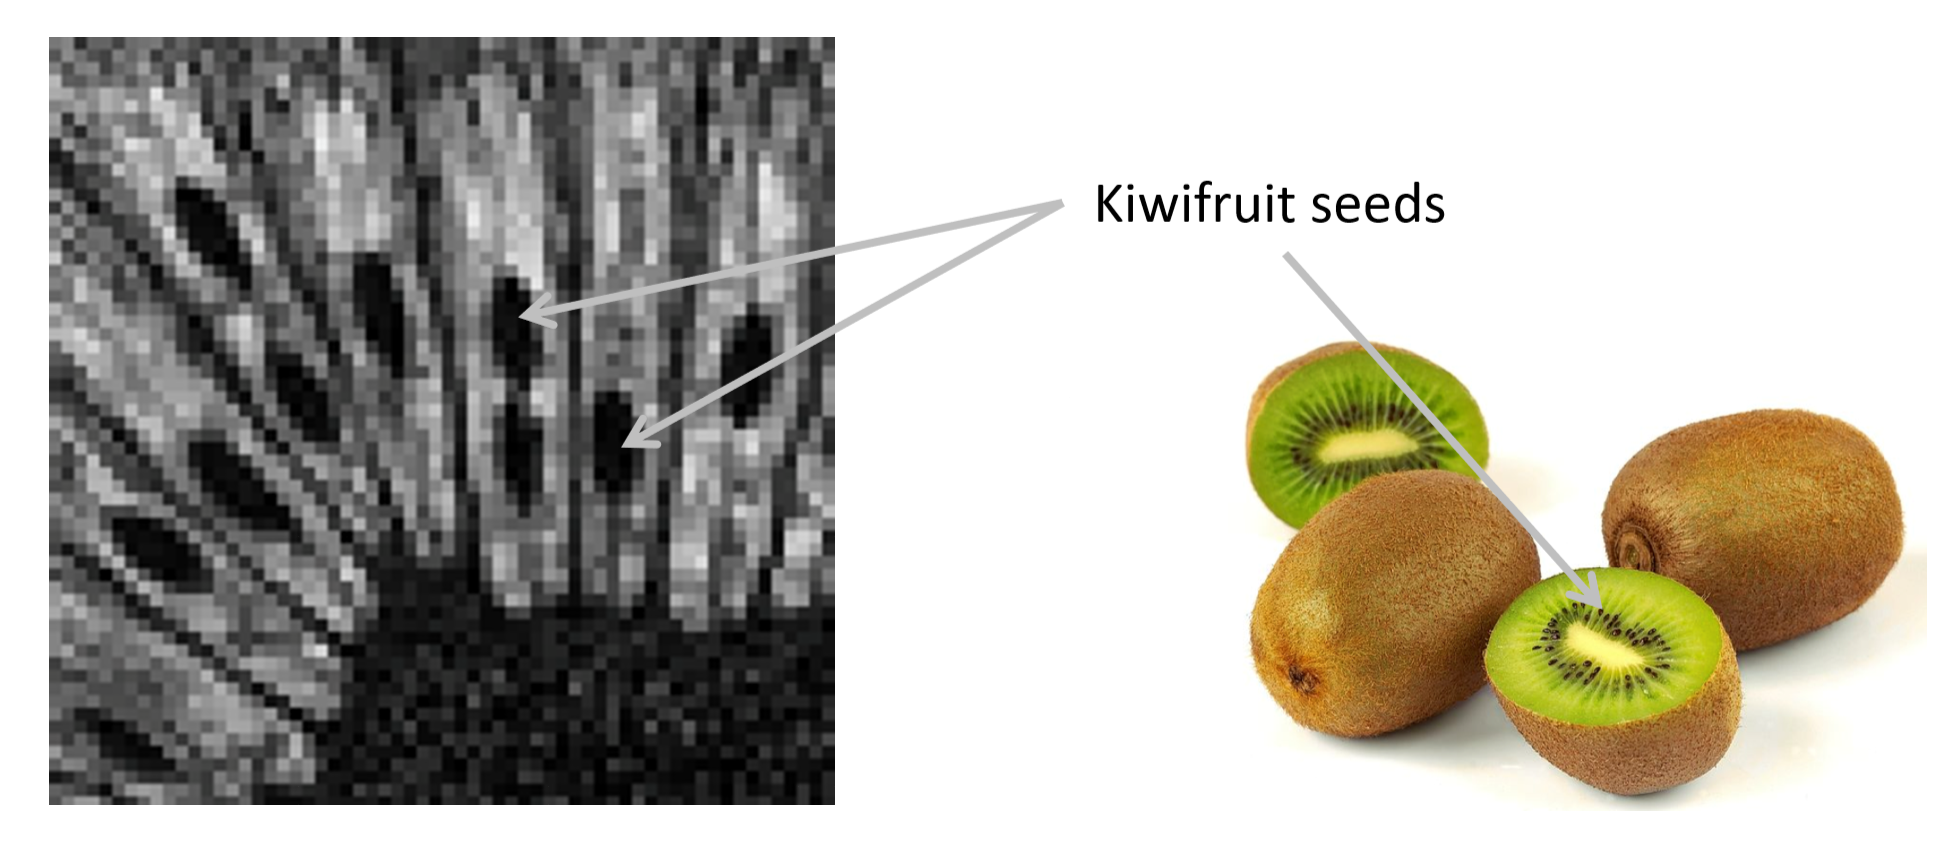

In [2]:
Image(filename='./assets/kiwi_seed_segmentation_task.png', width=600)

Segmentation task:
----------------

**DATA**

The 3D dataset, consisting of 128 transaxial slices through the long axis of
the kiwi, was acquired with the 7 T [Bruker Pharmascan](https://www.bruker.com/products/mr/preclinical-mri/pharmascan/overview.html) MRI scanner at the
MIC / Vivarium, University of Bergen, using the 2D [RARE pulse sequence](http://mriquestions.com/what-is-fsetse.html)
(Echo Train Length = 8, TR = 18520 ms, TE = 63.9 ms, No. of Averages = 2,
Flip Angle = 180 deg, Slice thickness = 0.5 mm, In-plane pixel resolution =
0.234 x 0.234 mm2, Acquisition matrix = 256 x 256, Number of slices = 128).

**TASK**

- **a)**  Segment the **seeds from the background** using all the clever tricks / ideas you can come up with (e.g. adaptive thresholding, template matching / a priori information, Fourier space methods, …). Try out both 2D and 3D approaches.       (Use  PYTHON or MATLAB or JAVA or …)<br><br>

- **b)** From your  segmentation results, make an estimate of the **number of seeds** in the Kiwi. If you are using probabilistic methods you might also provide a confidence interval for your estimate. <br><br>

- **c)** Try to assess the **goodness of your segmentation** method by cutting out a portion of the volume (e.g. some contiguous slices) and do a manual count of the number of seeds and compare with your segmentation results (e.g. false positive detections, false negative detections). <br><br>

- **d)** Now, consider the Kiwi to be the brain and the seeds to be pathological lesions, such as MS plaques. Make an estimate of the “**lesion load**”, i.e. the ratio: volume of lesions (seeds) / volume of whole brain (kiwi), using the voxel size information from the scan and your segmentation results.<br><br>

- **e)** Write a **short scientific report** from your investigation, with a<br><br>
   - __Title__, an
   - __Introduction__ with problem formulation, 
   - __Materials and methods__ regarding test object (kiwifruit), image acquisition and the image analysis methods
       being used (your algorithm / code can be given in an Appendix);
   - __Experimental results__ (seed counts for given algorithmic parameter settings, processing time, etc., use Figures and Tables to describe your results); 
   - __Discussion__ (main results, strength and weaknesses of your approach, suggestions for improvement, relevance to similar problems, conclusions).
   - __Bibliography__ (try to find some relevant literature to this image analysis task, and your algorithmic approach). 
   
_Report and code (notebook) should be sent by e-mail to arvid.lundervold [at] gmail.com at latest on the Sunday before the 2nd period of the course._

### Import libraries

In [3]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import skimage

home = os.path.expanduser('~')  # home is to make path to local home directory
#print('home: %s' % home)

Read the data and explore the data
------------------------------

In [4]:
mydata = '../data/mri/kiwi'
img_name = '20050217191129_RARE_high_res_axial_131073'
fn = '%s/%s.nii.gz' % (mydata, img_name)

In [5]:
img = nib.load(fn)

In [6]:
print('img.get_filename() =', img.get_filename())
print('shape of image = ', img.header.get_data_shape())
print('voxel size = ', img.header.get_zooms())
print('units = ', img.header.get_xyzt_units()[0])
print('dtype = %s' % img.header.get_data_dtype())

img.get_filename() = ../data/mri/kiwi/20050217191129_RARE_high_res_axial_131073.nii.gz
shape of image =  (256, 256, 128)
voxel size =  (0.234375, 0.234375, 0.5)
units =  mm
dtype = int16


In [7]:
data = img.get_data()

print('data shape', data.shape)
print('min = %d' % data.min())
print('max = %d' % data.max())
print('mean = %.f' % data.mean())
print('std = %.2f' % data.std())
print('number of slices =', img.shape[-1])
print('total number of voxels =', data.flatten().size)

data shape (256, 256, 128)
min = 71
max = 32766
mean = 3375
std = 4987.20
number of slices = 128
total number of voxels = 8388608


> **CHECK:** 
>
> - *Coordiante systems and affine transforms in medical imaging (e.g. [nibabel](http://nipy.org/nibabel/coordinate_systems.html) / [nilearn](http://nilearn.github.io/auto_examples/04_manipulating_images/plot_affine_transformation.html))*
> - *Converting from DICOM-format (privided by the scanner) to NIFTI-format for processing (e.g. [dcm2nii](https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage) og [dcm2niix](https://github.com/rordenlab/dcm2niix))*

In [8]:
aff = img.affine
print('affine header:\n', aff)

affine header:
 [[ -0.234375   0.        -0.        27.      ]
 [ -0.         0.234375  -0.       -26.265625]
 [  0.         0.         0.5      -30.75    ]
 [  0.         0.         0.         1.      ]]


Visualize the 3D image data
---------------------------------

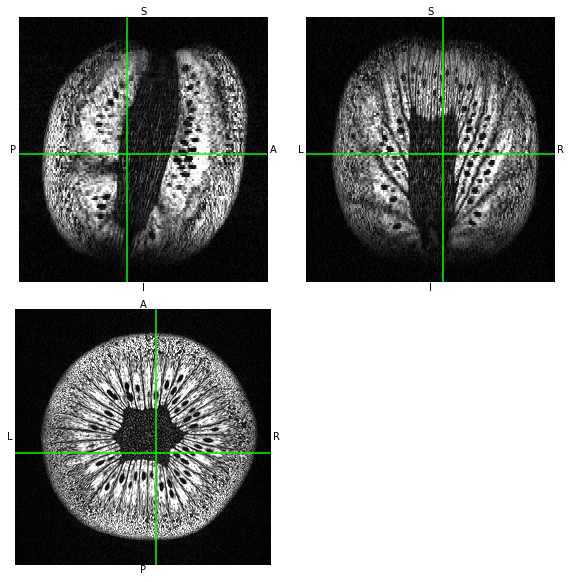

In [9]:
from nibabel.viewers import OrthoSlicer3D
OrthoSlicer3D(img.get_data(), affine= img.affine).show()

Number of slices: 128


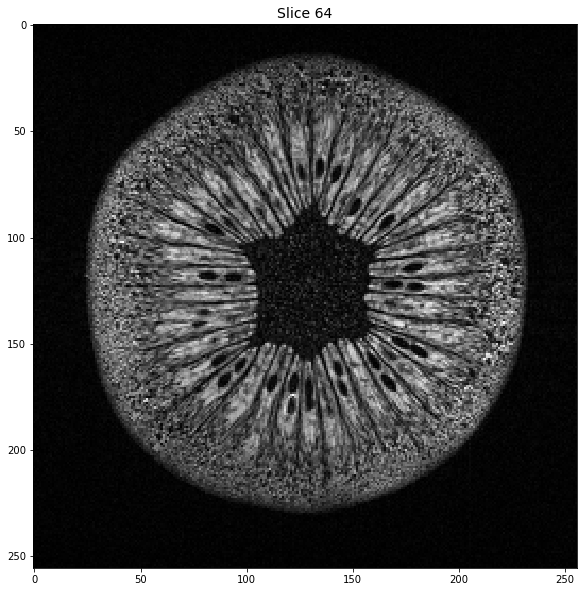

In [10]:
# Split the 3D numpy array into 2D slices
slices = list(np.split(data, data.shape[2], axis=2))
print('Number of slices:', len(slices))

sl = 64
fig, ax = plt.subplots(1,1, figsize=(10, 10))
plt.imshow(np.matrix(slices[sl]), cmap='gray')
ax.set_title('Slice %d' % (sl), fontsize=14)
plt.show()

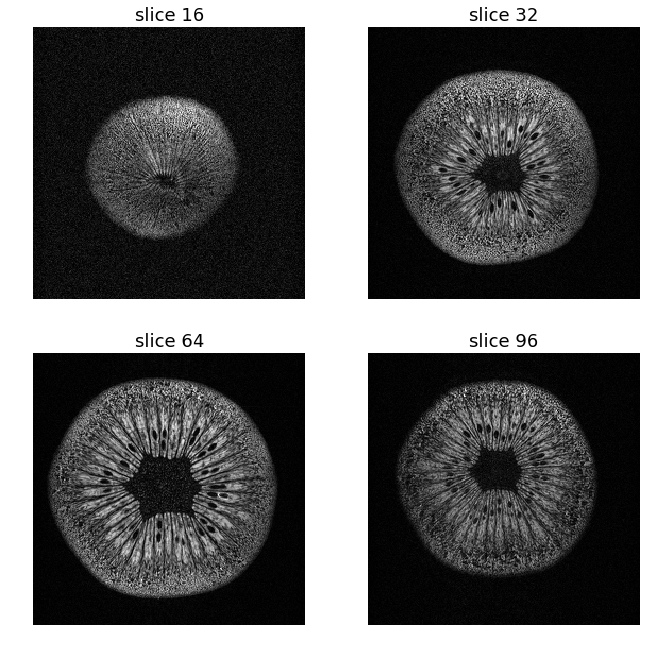

In [11]:
s = [16, 32, 64, 96]
fig = plt.figure('Showing the kiwi image', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('slice %d' % s[0], fontsize=18)
plt.imshow(data[:, :, s[0]].T, cmap='gray', origin='lower')  # .T for transpose to correct orientation
plt.subplot(2, 2, 2).set_axis_off(), plt.title('slice %d' % s[1], fontsize=18)
plt.imshow(data[:, :, s[1]].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('slice %d' % s[2], fontsize=18)
plt.imshow(data[:, :, s[2]].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('slice %d' % s[3], fontsize=18)
plt.imshow(data[:, :, s[3]].T, cmap='gray', origin='lower')
plt.show()

#fig.savefig('%s/prj/BMED360/results/flash_dess_fisp_psif_channel_images.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

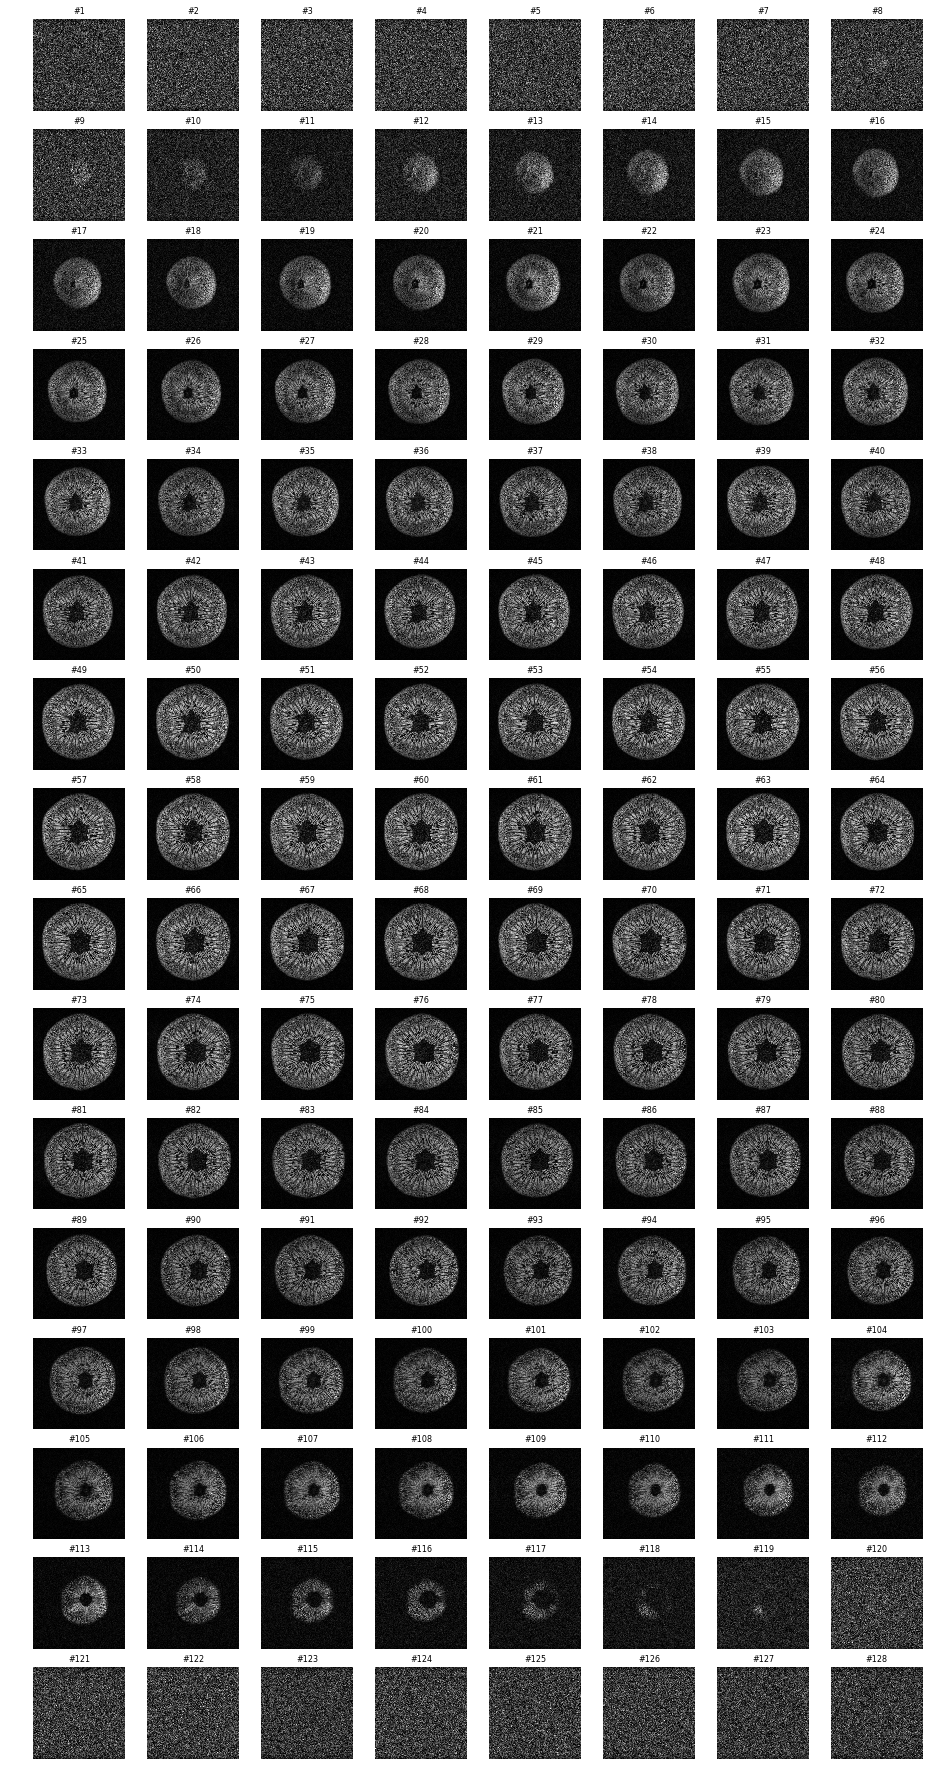

In [12]:
fig, axes = plt.subplots(16, 8, figsize=(16, 32))
ax = axes.ravel()

for i, im in enumerate(slices):
    ax[i].imshow(np.matrix(im), cmap='gray')
    ax[i].set_title('#%d' % (i+1), fontsize=8)
    ax[i].axis('off')

plt.show()

**Save central slice (sl=64) as a PNG image file - using** 
 Pillow, Matplotlib, CV2, skimage, and imageio
-------------------

In [46]:
def data_matrix_info(M):
    print('data shape', M.shape)
    print('min = %d' % M.min())
    print('max = %d' % M.max())
    print('mean = %.4f' % M.mean())
    print('std = %.4f' % M.std())

In [47]:
fn = '%s/kiwi_%03d.png' % (mydata, sl)
A = np.matrix(slices[sl])
fn

'../data/mri/kiwi/kiwi_064.png'

In [48]:
data_matrix_info(A)

data shape (256, 256)
min = 71
max = 32766
mean = 5973.3852
std = 6547.6558


**Pillow (PIL):** (will save and restore the original MRI signal intensities in matrix A)

In [49]:
import PIL
im = PIL.Image.fromarray(A)
im.save(fn)

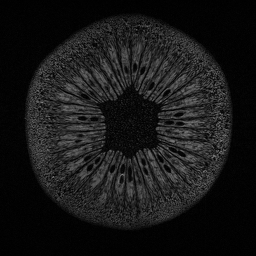

In [50]:
from IPython.display import Image
Image(filename=fn, width=256)

In [51]:
A_pil = PIL.Image.open(fn)
A_PIL = np.array(A_pil)
print('A_PIL:')
data_matrix_info(A_PIL)

A_PIL:
data shape (256, 256)
min = 71
max = 32766
mean = 5973.3852
std = 6547.6558


**Matplotlib:**

In [52]:
import matplotlib
matplotlib.image.imsave(fn, A)

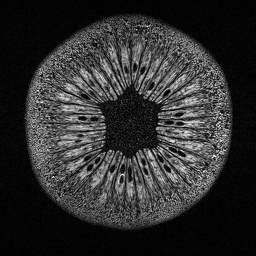

In [53]:
Image(filename=fn, width=256)

In [54]:
#A_matplotlib = matplotlib.image.imread(fn, format='png')
A_matplotlib = matplotlib.image.imread(fn)
print('A_matplotlib:')
data_matrix_info(A_matplotlib)

A_matplotlib:
data shape (256, 256, 4)
min = 0
max = 1
mean = 0.3843
std = 0.3958


**OpenCV (CV2):**

In [55]:
import cv2
cv2.imwrite(fn, A)

True

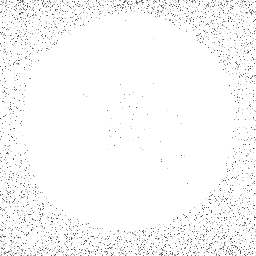

In [56]:
Image(filename=fn, width=256)

In [57]:
#A_cv2 = cv2.imread(fn, cv2.IMREAD_UNCHANGED)
A_cv2 = cv2.imread(fn)
print('A_cv2:')
data_matrix_info(A_cv2)

A_cv2:
data shape (256, 256, 3)
min = 71
max = 255
mean = 248.9274
std = 26.7931


In [58]:
A_cv2 = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
print('A_cv2:')
data_matrix_info(A_cv2)

A_cv2:
data shape (256, 256)
min = 71
max = 255
mean = 248.9274
std = 26.7931


**skimage:**

In [59]:
from skimage.io import imsave
imsave(fn, A)

Lossy conversion from int16 to uint8. Range [71, 32766]. Convert image to uint8 prior to saving to suppress this warning.


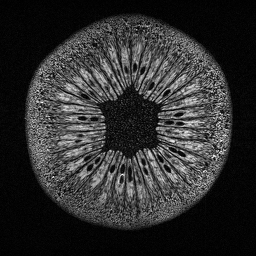

In [60]:
Image(filename=fn, width=256)

In [61]:
from skimage import io
A_skimage= io.imread(fn)
print('A_skimage:')
data_matrix_info(A_skimage)

A_skimage:
data shape (256, 256)
min = 0
max = 255
mean = 46.0339
std = 51.0688


**imageio:**

In [62]:
import imageio
imageio.imwrite(fn, A)

Lossy conversion from int16 to uint8. Range [71, 32766]. Convert image to uint8 prior to saving to suppress this warning.


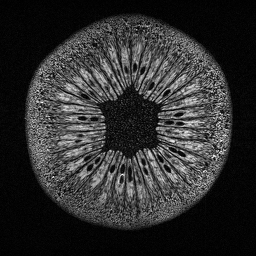

In [63]:
Image(filename=fn, width=250)

In [64]:
A_imageio = imageio.imread(fn)
print('A_imageio:')
data_matrix_info(A_imageio)

A_imageio:
data shape (256, 256)
min = 0
max = 255
mean = 46.0339
std = 51.0688


**So we will use PIL to store and retrieve image data to a PNG file  ...**

In [65]:
im = PIL.Image.fromarray(A)
im.save(fn)

Segmenting a single central slice ...
=========================

Consider use of the [image segmentation toolboxes](https://scikit-image.org/docs/0.15.x/user_guide/tutorial_segmentation.html) in scikit-image among a large range of image processing and analysis methods (see [examples]( https://scikit-image.org/docs/0.15.x/auto_examples)).

_Image segmentation_ is the process of partitioning a digital image into multiple segments (sets of pixels or voxels) in order to  is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze, e.g.  [[1](https://en.wikipedia.org/wiki/Image_segmentation)]. <br>You could start with exploring the kiwi seed segmentation task in a single slice before addressing the whole kiwi, using thresholding and filtering techniques.

In [66]:
skimage.__version__

'0.15.0'

**Read the PNG slice image**

In [67]:
A_pil = PIL.Image.open(fn)
image = np.array(A_pil)

### Thresholding

[Thresholding](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_thresholding.html) is used to create a binary image from a grayscale image [[1](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29)]. It is the simplest way to segment objects from a background.

Thresholding algorithms implemented in scikit-image can be separated in two categories:

 - **Histogram-based**. The histogram of the pixels’ intensity is used and certain assumptions are made on the properties of this histogram (e.g. bimodal).<br><br>
 - **Local**. To process a pixel, only the neighboring pixels are used. These algorithms often require more computation time.
If you are not familiar with the details of the different algorithms and the underlying assumptions, it is often difficult to know which algorithm will give the best results. Therefore, Scikit-image includes a function to evaluate thresholding algorithms provided by the library. At a glance, you can select the best algorithm for you data without a deep understanding of their mechanisms.
```python
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(image, figsize=(10, 8), verbose=False)
plt.show()
```

See also [here](https://www.slideshare.net/sharmashrushrita/image-thresholding-with-scikitimage)

### Filtering

**Check performance of some filtering procedures**  for which there are [numerous](https://scikit-image.org/docs/0.15.x/api/skimage.filters.html) in scikit-image.

 - [Attribute operators](https://scikit-image.org/docs/0.15.x/auto_examples/filters/plot_attribute_operators.html)
 - Clustering-based image thresholding [Otsu's method](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_otsu)   (see also [Wikipedia](https://en.wikipedia.org/wiki/Otsu%27s_method))
 - [Threshold local](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_local)    (se also [here](https://stackoverflow.com/questions/49459459/threshold-local-returns-a-different-result-than-threshold-adaptive-in-scikit-ima))

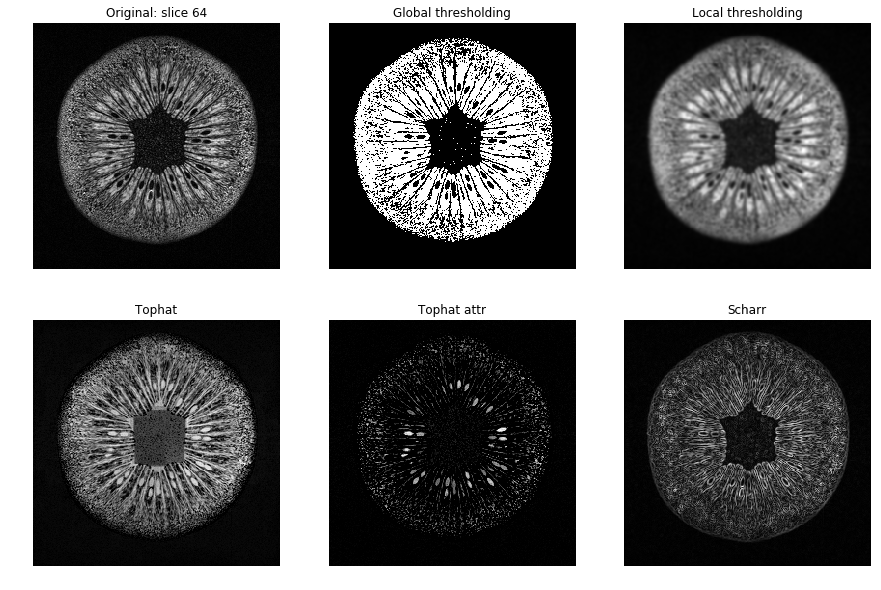

In [102]:
from skimage.filters import *
from skimage.morphology import closing
from skimage.morphology import square
from skimage.morphology import diameter_closing
from skimage.segmentation import active_contour


# image = data.page()

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 9
binary_local = threshold_local(image, block_size, offset=10)

# Diameter closing : we remove all dark structures with a maximal
# extension of less than <diameter> (12 or 23). I.e. in closed_attr, all
# local minima have at least a maximal extension of <diameter>.
diameter = 20
closed_attr = diameter_closing(image, diameter, connectivity=2)

# We then calculate the difference to the original image.
tophat_attr = closed_attr - image
    

# A morphological closing removes all dark structures that cannot
# contain a structuring element of a certain size.
closed = closing(image, square(diameter))

# Again we calculate the difference to the original image.
tophat = closed - image


edges = scharr(image)

ncols = 3
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 10))

ax = axes.ravel()

plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original: slice %d' % (sl))

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

ax[3].imshow(tophat)
ax[3].set_title('Tophat')

ax[4].imshow(tophat_attr)
ax[4].set_title('Tophat attr')

ax[5].imshow(edges)
ax[5].set_title('Scharr')

for i in range(ncols*nrows):
    ax[i].axis('off')

plt.show()

## What to try ?

### - Using selected filtered images as multispectral images and input to [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) ?

### - Manual labelling of all seeds in a couple of slices ([ITK-SNAP](http://www.itksnap.org/pmwiki/pmwiki.php)), used for training a deep [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network) ?

### - Use [radiomics](http://radiomics.io) to derive new feature images for unsupervised or supervised classification of seeds ?

## K-means clustering approach

In [151]:
# Make X -  n x p data matrix, n=samples, p = feature vector dimension

chn_names = ['Original', 'Local_thresholding', 'Tophat_attr']

X1 = image.flatten()
X2 = binary_local.flatten()
X3 = tophat_attr.flatten()

X = np.column_stack((X1, X2, X3))
X.shape

(65536, 3)

### Clustering the multispectral data matrix X

In [152]:
from sklearn.cluster import KMeans

K = 5  # Number of clusters
kmeans_model = KMeans(n_clusters=K, random_state=42)
print(kmeans_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


In [153]:
# Fit the K-means model to the data
kmeans_fit = kmeans_model.fit(X)

In [154]:
print(kmeans_fit.labels_)
print('First centroid i p-dimensional feature vector space:\n', kmeans_fit.cluster_centers_[0,:])

[1 1 1 ... 1 1 1]
First centroid i p-dimensional feature vector space:
 [4155.17117264 8382.02948972 3198.27947883]


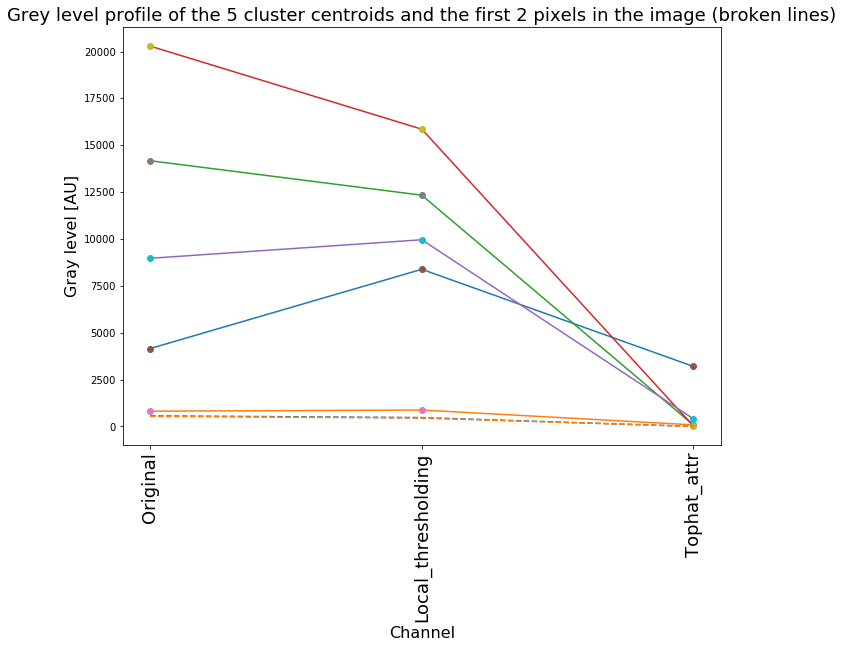

In [155]:
# Plot the cluster centroids as line plots

nv = 2

fig, ax = plt.subplots(1,1)

fig.set_size_inches(10, 7)

plt.plot(kmeans_fit.cluster_centers_.T)
plt.plot(kmeans_fit.cluster_centers_.T, 'o')
plt.plot(X[:nv, :].T, '--')
plt.xlabel('Channel', fontsize=16)
ax.set_xticks([x for x in range(len(chn_names))])
ax.set_xticklabels(chn_names, rotation='vertical', fontsize=18)
plt.ylabel('Gray level [AU]', fontsize=16)
#plt.xlim(0, 3)
plt.title('Grey level profile of the %d cluster centroids and the first %d pixels in the image (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

**Make a k-means segmented image**

In [156]:
kmeans_segm = 0 * image.copy()
print('Size of segmented image:', kmeans_segm.shape)
print('min:', kmeans_fit.labels_.min())
print('max:', kmeans_fit.labels_.max())
print('Number of clustered samples within ROI:', len(X1))

Size of segmented image: (256, 256)
min: 0
max: 4
Number of clustered samples within ROI: 65536


**Assign the cluster belonging to each pixel**

In [157]:
k=0
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        kmeans_segm[i,j] = kmeans_fit.labels_[k]
        k=k+1

**and display the result (comparing with the original slice image)**

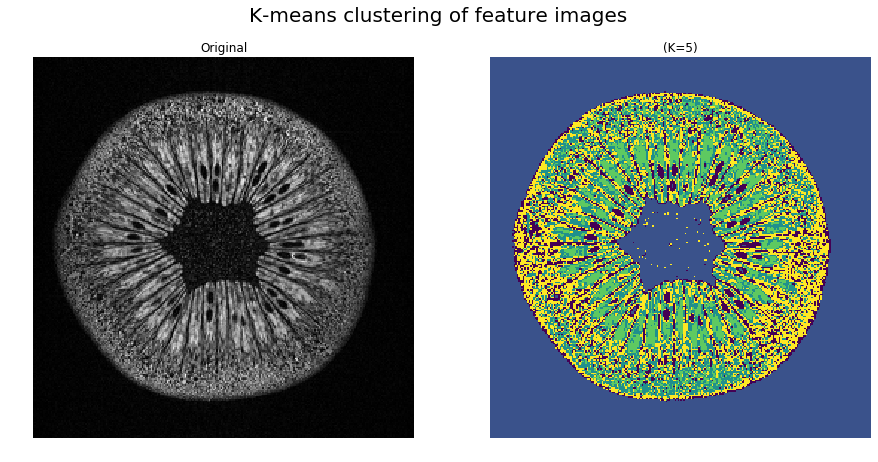

In [158]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
ax = axes.ravel()
ax[0].imshow(image[:, :].T, cmap='gray', origin='lower')
ax[0].set_title(chn_names[0])
ax[0].set(xlabel="")
ax[0].axis('off')
ax[1].imshow(kmeans_segm[:, :].T, cmap='viridis', origin='lower')
ax[1].set_title('(K=%d)' % (K))
ax[1].axis('off')
plt.suptitle("K-means clustering of feature images", fontsize=20) 
plt.tight_layout
plt.show()

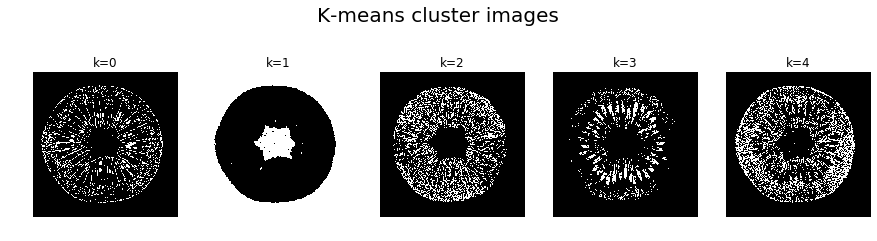

In [172]:
fig, axes = plt.subplots(1,K, figsize=(15,4))
ax = axes.ravel()
for k in range(K):
    ind = np.where(kmeans_segm == k)
    clu = 0*image.copy()
    clu[ind[0][:],ind[1][:]] = 1
    ax[k].imshow(clu[:, :].T, cmap='gray', origin='lower')
    ax[k].set_title('k=%d' % (k))
    ax[k].axis('off')
    
plt.suptitle("K-means cluster images", fontsize=20)
plt.show()